The process of this notebook is to prepare a dataset for trait identification.

In [1]:
import pandas as pd

def process(text: str):
    from parse import compile
    from string import punctuation

    p = compile("{hit:d}.")
    in_list = text.split()
    out_list = list()
    for seg in in_list:
        parse_result = p.parse(seg)
        if parse_result:
            # We got a number with a dot afterward:
            out_list.append(seg.lower())
        else:
            out_list.append(seg.translate(str.maketrans("", "", punctuation)).lower())
    return " ".join(out_list)



df = pd.read_json("ParlaSpeech-HR.v1.0.jsonl", orient="records", lines=True)
df["audio_length"] = df.end-df.start
df = df[df.audio_length >= 8]
df = pd.concat([df, df.speaker_info.apply(pd.Series)], axis=1)
df.head(3)

,path,orig_file,start,end,words,word_start_times,norm_words,norm_words_start_times,utterance_id_start,utterance_id_end,...,norm_words_edited,audio_length,Speaker_role,Speaker_type,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth
0,rFVDr4ghXlQ_10620.07-10632.05.wav,"20 2 2020 - 1. dio, 16. sjednica, 9. saziv [rF...",10620.07,10632.05,"[interpretacija,, inzistiranje, na, tim, dezin...","[0, 1.0, 1.83, 1.96, 2.22, 3.79, 4.01, 4.43, 5...","[interpretacija, inzistiranje, na, tim, dezinf...","[0, 1.0, 1.83, 1.96, 2.22, 3.79, 4.01, 4.43, 5...",ParlaMint-HR_S16.u4568,ParlaMint-HR_S16.u4568,...,NaN,11.98,Regular,MP,HDZ,Klub Hrvatske demokratske zajednice,Coalition,"Tuđman, Miroslav",M,1946
1,Ki_SnDM_EkQ_2917.58-2937.5.wav,"18 10 2018 - 9. sjednica, 9. saziv [Ki_SnDM_Ek...",2917.58,2937.50,"[izraelska, tvrtka, prodaje, avione, Hrvatskoj...","[0, 0.65, 1.04, 1.54, 1.92, 2.51, 3.11, 3.5700...","[izraelska, tvrtka, prodaje, avione, hrvatskoj...","[0, 0.65, 1.04, 1.54, 1.92, 2.51, 3.11, 3.5700...",ParlaMint-HR_S09.u4267,ParlaMint-HR_S09.u4267,...,NaN,19.92,Regular,MP,"Živi zid, SNAGA",Klub Živog zida i SNAGA-e,Opposition,"Bunjac, Branimir",M,1972
2,XguZsDKdRh4_13797.59-13811.74.wav,"20 1 2017 - 3. sjednica, 9. saziv [XguZsDKdRh4...",13797.59,13811.74,"[jučer, trećem,, sutra, ili, prekosutra, četvr...","[0, 0.43, 1.0, 1.4, 1.52, 2.01, 2.55, 3.12, 3....","[jučer, trećem, sutra, ili, prekosutra, četvrt...","[0, 0.43, 1.0, 1.4, 1.52, 2.01, 2.55, 3.12, 3....",ParlaMint-HR_S03.u9702,ParlaMint-HR_S03.u9702,...,NaN,14.15,Regular,MP,HDZ,Klub Hrvatske demokratske zajednice,Coalition,"Bačić, Branko",M,1959


In [2]:
df.columns

Index(['path', 'orig_file', 'start', 'end', 'words', 'word_start_times',
       'norm_words', 'norm_words_start_times', 'utterance_id_start',
       'utterance_id_end', 'speaker_info', 'split', 'norm_words_edited',
       'Speaker_role', 'Speaker_type', 'Speaker_party', 'Speaker_party_name',
       'Party_status', 'Speaker_name', 'Speaker_gender', 'Speaker_birth'],
      dtype='object')

# Include party orientation

where data exists.

In [4]:
HR_party_orientation = {
'SDP':'center-left',
'HDZ':'center-right',
'Most':'right',
'Nezavisni':None,
'HSU, SNAGA, NZ i NP':'center-left',
'SDSS':'center-left',
'HNS':'center-left',
'BM 365 i NZ':'center-left',
'Živi zid, SNAGA':None,
'HSS i Demokrati':'center-right',
'GLAS':'center-left',
'HDS, HSLS, HDSSB':'center-right',
'NLM':'center-right',
'Živi zid i PH':None,
'IDS, PGS, RI':'center-left',
'HS':'right'}

df["Speaker_party_orientation"] = df.Speaker_party.apply(lambda i: HR_party_orientation.get(i, None))


In [5]:
df.Speaker_party_orientation.isna().sum()/df.Speaker_party_orientation.shape[0]

0.2342415052299313

# Calculate speaker age at the date of recording

In [5]:
from datetime import datetime
def get_date_from_filename(s: str)->datetime:
    from parse import compile
    pattern = "{day:d} {month:d} {year:d} {rest}"

    p = compile(pattern)
    results = p.search(s)

    if not results:
        return None
    return datetime(results["year"], results["month"], results["day"])

df["recording_datetime"] = df.orig_file.apply(get_date_from_filename)


In [6]:
def get_speaker_age_at_recording(row):
    try:
        return row["recording_datetime"].year - int(row["Speaker_birth"])
    except ValueError:
        return None

df["Speaker_age_at_recording"] = df.apply(get_speaker_age_at_recording, axis=1)

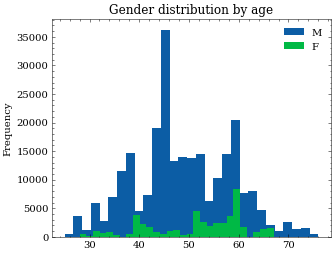

In [7]:
import matplotlib.pyplot as plt

try:
    plt.style.use("science no-latex".split())
except:
    pass
genders = ["M", "F"]

fig, ax = plt.subplots(figsize=(5, 4))
for gender in genders:
    df[df.Speaker_gender == gender].Speaker_age_at_recording.plot(
        kind="hist", ax=ax, label=gender, bins=29
    )
plt.legend()
plt.title("Gender distribution by age")
plt.show()


# THird approach

In [8]:
df = df[df.audio_length >= 8]

In [9]:
df.columns

Index(['path', 'orig_file', 'start', 'end', 'words', 'word_start_times',
       'norm_words', 'norm_words_start_times', 'utterance_id_start',
       'utterance_id_end', 'speaker_info', 'split', 'norm_words_edited',
       'audio_length', 'Speaker_role', 'Speaker_type', 'Speaker_party',
       'Speaker_party_name', 'Party_status', 'Speaker_name', 'Speaker_gender',
       'Speaker_birth', 'recording_datetime', 'Speaker_age_at_recording'],
      dtype='object')

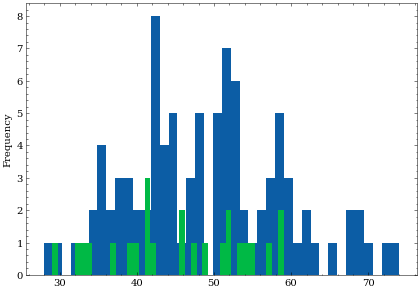

In [10]:
gb = df.groupby("Speaker_name").agg({
    "path": "count",
    "Speaker_age_at_recording": "median",
    "Speaker_gender": lambda i: i.iloc[0],
}).rename(columns={"path": "Count"}).sort_values(by="Count", ascending=False)
gb =  gb.loc[(gb.Count > 200) & (gb.Count < 3000)]

for gender in "MF":
    gb.Speaker_age_at_recording[gb.Speaker_gender == gender].plot(kind="hist", bins=40, figsize=(7,5))

In [11]:
sum(gb.Speaker_gender == "F")

41

In [12]:
C_is_female = gb.Speaker_gender == "F"
C_is_male = gb.Speaker_gender == "M"

females_train = gb.loc[C_is_female].index[0:25].tolist()
males_train = gb.loc[C_is_male].index[0:25].tolist()

females_test = gb.loc[C_is_female].index[25:25+5].tolist()
males_test = gb.loc[C_is_male].index[25:25+5].tolist()

females_dev = gb.loc[C_is_female].index[25+5:25+10].tolist()
males_dev = gb.loc[C_is_male].index[25+5:25+10].tolist()

In [13]:
train_gender = pd.concat([
    df[df.Speaker_name == name][0:20] for name in females_train+males_train
])
test_gender = pd.concat([
    df[df.Speaker_name == name][0:200] for name in females_test+males_test
])
dev_gender = pd.concat([
    df[df.Speaker_name == name][0:200] for name in females_dev+males_dev
])

In [14]:
train_gender.shape, test_gender.shape, dev_gender.shape

((1000, 24), (2000, 24), (2000, 24))

In [12]:
len(females_train), len(males_train), len(females_test), len(males_test)

(25, 25, 5, 5)

In [15]:
files_to_move = train_gender.path.tolist()+test_gender.path.tolist()+dev_gender.path.tolist()

In [16]:
with open("001_files_to_move.txt", "w") as f:
    f.writelines(["seg."+ i + "\n" for i in files_to_move])

In [17]:
train_gender.to_csv("001_gender_train.csv", index=False)
test_gender.to_csv("001_gender_test.csv", index=False)
dev_gender.to_csv("001_gender_dev.csv", index=False)

In [18]:
set(females_train).intersection(set(females_test))

set()

In [19]:
set(males_train).intersection(set(males_test))

set()

In [21]:
set(males_dev).intersection(set(males_test)), set(males_train).intersection(set(males_dev)), set(females_dev).intersection(set(females_test))

(set(), set(), set())